In [335]:
import numpy as np
import pandas as pd
from vnstock import Vnstock
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import gaussian_kde
from scipy.stats import beta, dirichlet, norm,invwishart, invgamma, beta
from scipy.special import gammaln, gamma
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import time
from datetime import datetime
from scipy import stats


# 0. OVERVIEW

In [336]:
# Load Stock Data
stock = Vnstock().stock()
ASSETS = ["HPG", "VCB", "CTG", "MSN", "MWG"]

#choose historical data of 9 stocks in 5-year period (2020-2025)
start_date = "2020-01-01"
end_date = "2025-01-01"

data= pd.DataFrame()
for ticker in ASSETS:
    stock = Vnstock().stock(symbol= ticker, source='VCI')
    data[ticker] = stock.quote.history(start=start_date, end=end_date)["close"]
data = data.set_index(stock.quote.history(start=start_date, end=end_date)["time"])

2025-07-12 18:27:15 - vnstock.common.vnstock - INFO - Mã chứng khoán không được chỉ định, chương trình mặc định sử dụng VN30F1M
2025-07-12 18:27:15 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.


In [337]:
#view historical price of the portfolio
data.head()

,HPG,VCB,CTG,MSN,MWG
time,,,,,
2020-01-02,8.28,39.49,14.35,46.12,37.43
2020-01-03,8.33,39.10,14.21,46.53,36.89
2020-01-06,8.28,38.06,14.25,45.80,36.70
2020-01-07,8.17,38.19,14.48,45.96,36.99
2020-01-08,8.09,37.84,14.45,45.32,36.09


In [338]:
#calculate daily log-return
daily_log_returns = np.log(data / data.shift(1)).dropna()
mean_returns = daily_log_returns.mean()
print(mean_returns)

HPG    0.000790
VCB    0.000348
CTG    0.000775
MSN    0.000334
MWG    0.000391
dtype: float64


In [339]:
#calculate covariance 
cov_matrix = daily_log_returns.cov()
print(cov_matrix)

          HPG       VCB       CTG       MSN       MWG
HPG  0.000495  0.000144  0.000267  0.000212  0.000254
VCB  0.000144  0.000267  0.000187  0.000127  0.000137
CTG  0.000267  0.000187  0.000492  0.000193  0.000247
MSN  0.000212  0.000127  0.000193  0.000508  0.000241
MWG  0.000254  0.000137  0.000247  0.000241  0.000521


In [340]:
RISK_FREE_RATE = 0.03

# Gibbs Sampling 

In [341]:
# Observed data: daily log returns
observed_daily_returns = daily_log_returns.values  # Shape: (n_days, n_assets)
n_observations, n_assets = observed_daily_returns.shape

n_assets = len(ASSETS)
n_observations = observed_daily_returns.shape[0]

In [342]:
import numpy as np

def prior_fucntions_params(returns):
    mu_hat = returns.mean(axis='rows') *252
    cov_hat = returns.cov() *252
    
    return mu_hat, cov_hat

In [343]:
from scipy.stats import invwishart, multivariate_normal

# === 2. Log returns ===
returns = np.log(data).diff().dropna().values  # shape (T, N)
T, N = returns.shape

# === 3. Prior hyperparameters ===
mu_0, psi_0 = prior_fucntions_params(returns=np.log(data).diff().dropna())
kappa_0 = 1
nu_0 = N + 2

# === 4. Gibbs Sampling Settings ===
n_iter = 20000
samples_mu = np.zeros((n_iter, N))
samples_cov = np.zeros((n_iter, N, N))

# === 5. Gibbs Sampling Loop ===
for i in range(n_iter):
    # --- Step 1: Sample Sigma | mu, R ---
    r_bar = np.mean(returns, axis=0)
    S = (returns - r_bar).T @ (returns - r_bar)
    psi_n = psi_0 + S + (kappa_0 * T / (kappa_0 + T)) * np.outer(r_bar - mu_0, r_bar - mu_0)
    nu_n = nu_0 + T
    cov = invwishart.rvs(df=nu_n, scale=psi_n)

    # --- Step 2: Sample mu | Sigma, R ---
    kappa_n = kappa_0 + T
    mu_n = (kappa_0 * mu_0 + T * r_bar) / kappa_n
    mu_cov = cov / kappa_n
    mu = multivariate_normal.rvs(mean=mu_n, cov=mu_cov)
    
    samples_mu[i] = mu * 252
    samples_cov[i] = cov * 252

# === 6. Posterior Summary ===
mean_mu = samples_mu.mean(axis=0) 
std_mu = samples_mu.std(axis=0)

print("Posterior Mean of Daily Log Returns:")
for i, name in enumerate(data.columns):
    print(f"{name}: {mean_mu[i]:.6f} ± {std_mu[i]:.6f}")

Posterior Mean of Daily Log Returns:
HPG: 0.239951 ± 0.177414
VCB: 0.105790 ± 0.128420
CTG: 0.235040 ± 0.177769
MSN: 0.101779 ± 0.176539
MWG: 0.118586 ± 0.180275


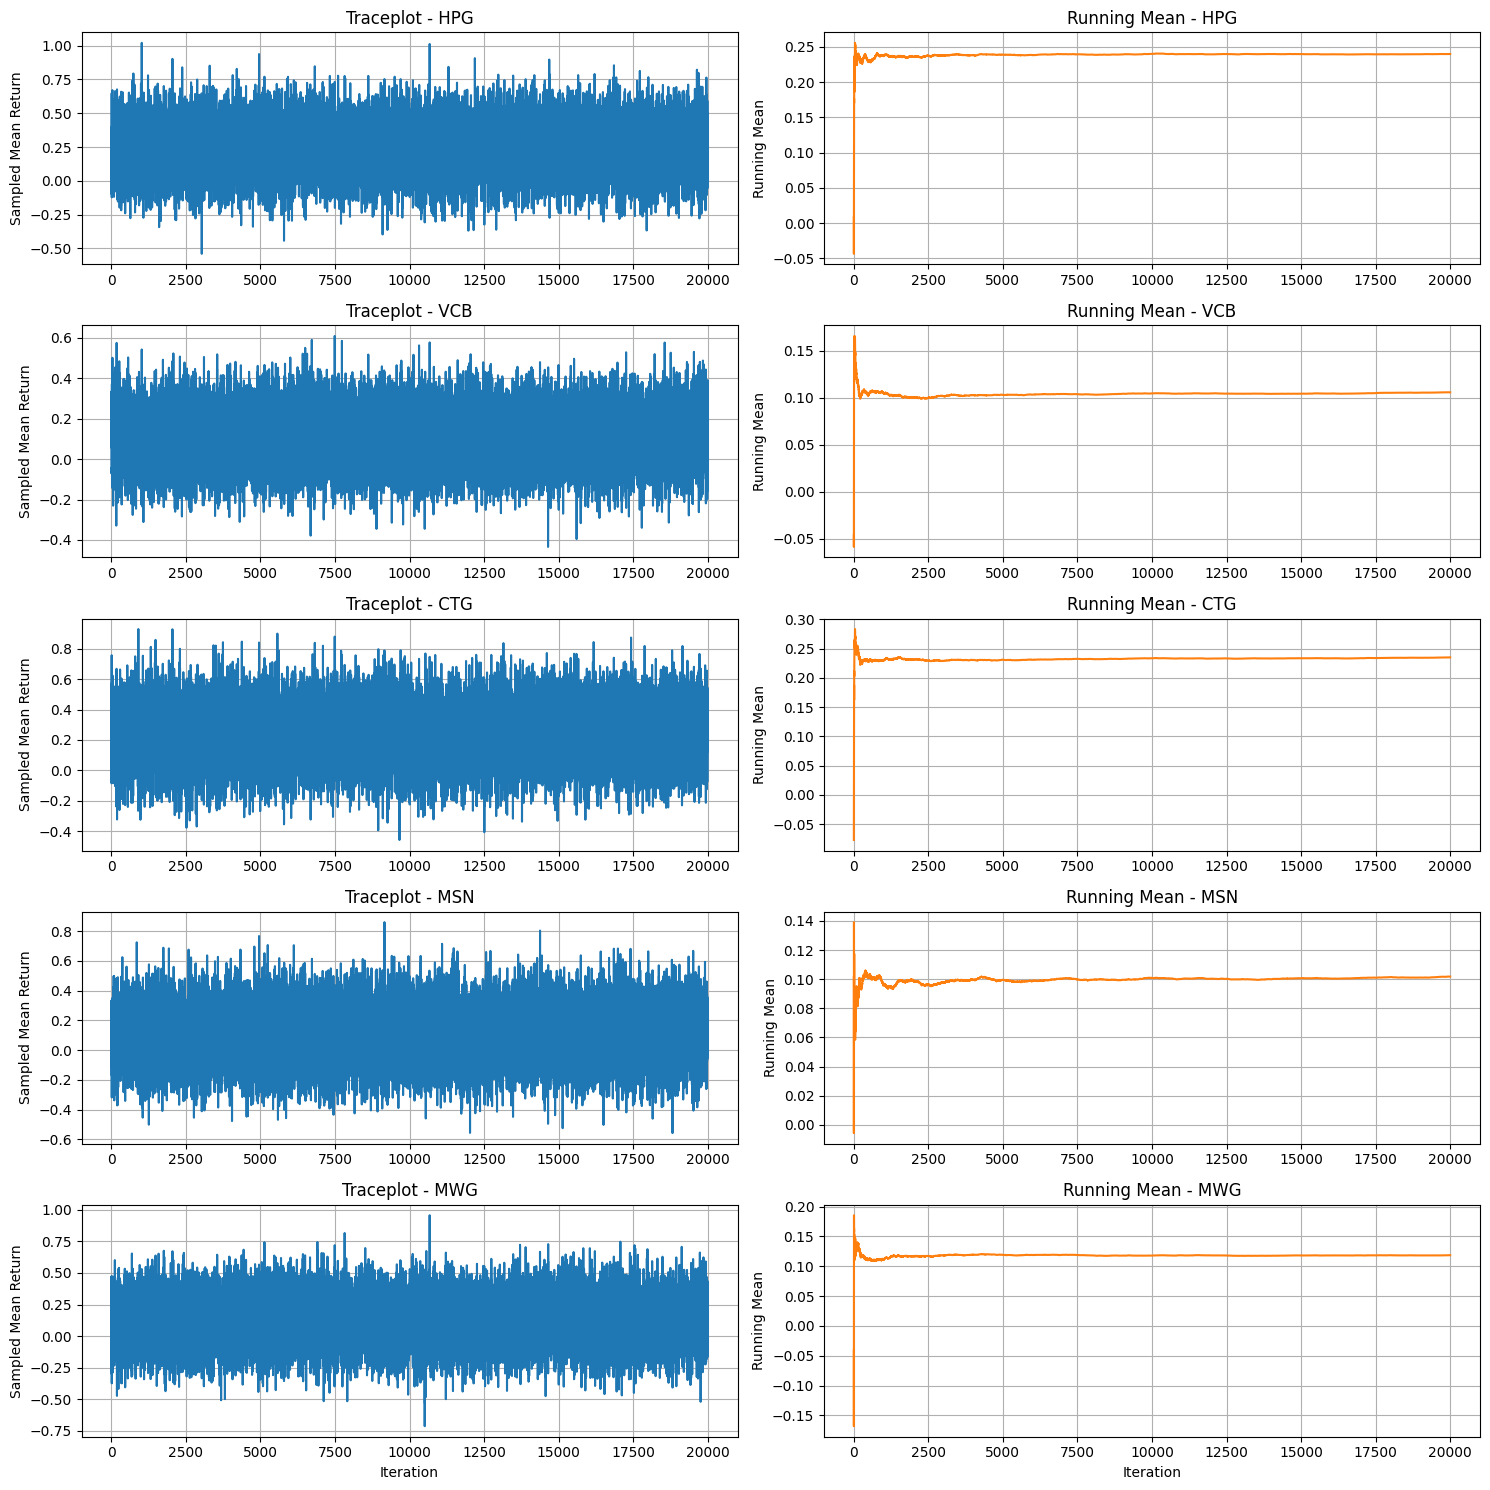

In [344]:
n_assets = samples_mu.shape[1]
fig, axes = plt.subplots(
    n_assets, 2, figsize=(15, 3 * n_assets), sharex=False
)

for asset_idx, name in enumerate(data.columns):
    # --- Traceplot ---
    ax_trace = axes[asset_idx, 0]
    ax_trace.plot(samples_mu[:, asset_idx], color='tab:blue')
    ax_trace.set_title(f"Traceplot - {name}")
    ax_trace.set_ylabel("Sampled Mean Return")
    ax_trace.grid(True)

    # --- Running Mean ---
    ax_runmean = axes[asset_idx, 1]
    running_mean = np.cumsum(samples_mu[:, asset_idx]) / np.arange(1, len(samples_mu)+1)
    ax_runmean.plot(running_mean, color='tab:orange')
    ax_runmean.set_title(f"Running Mean - {name}")
    ax_runmean.set_ylabel("Running Mean")
    ax_runmean.grid(True)

    if asset_idx == n_assets - 1:
        ax_runmean.set_xlabel("Iteration")
        ax_trace.set_xlabel("Iteration")

plt.tight_layout()
plt.show()


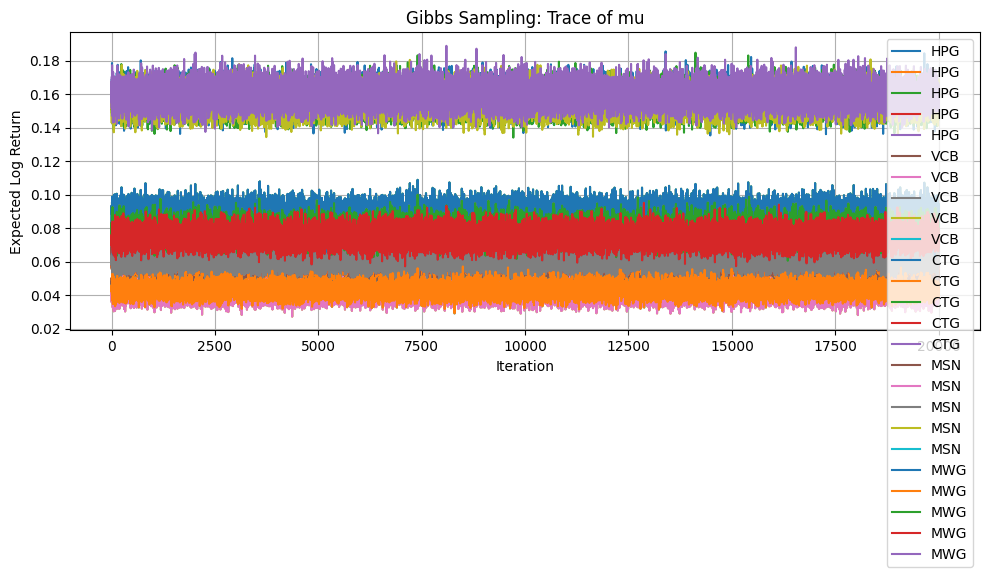

In [345]:
# Optional: plot trace
plt.figure(figsize=(10, 5))
for i, name in enumerate(data.columns):
    plt.plot(samples_cov[:, i], label=name)
plt.title("Gibbs Sampling: Trace of mu")
plt.xlabel("Iteration")
plt.ylabel("Expected Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [346]:
mu_post_mean = mean_mu.copy()
cov_post_mean = samples_cov.mean(axis=0)

check = pd.DataFrame( mu_post_mean.reshape(-1), index=data.columns, columns= ['Expected'] )
check['Volatility'] = np.sqrt(np.diag(cov_post_mean))

check

,Expected,Volatility
HPG,0.239951,0.396756
VCB,0.105790,0.286829
CTG,0.235040,0.395483
MSN,0.101779,0.393992
MWG,0.118586,0.399372


In [347]:
# ===Numbers of sample Gibbs ===
n_samples = samples_mu.shape[0]
n_assets = samples_mu.shape[1]

In [348]:
# === Negative Sharpe Ratio Function ===
def negative_sharpe(weights, mean_returns, cov_matrix):
    ret = np.sum(weights * mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(ret - RISK_FREE_RATE) / vol

In [349]:
# === Storage Results ===
results = {
    "weights": [],
    "return": [],
    "volatility": [],
    "sharpe": [],
}

# === Bounded ===
bounds = tuple((0, 1) for _ in range(n_assets))
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
initial_guess = np.repeat(1 / n_assets, n_assets)

# === Sampling Sharpe Ratio ===
for i in range(n_samples):
    mu_i = samples_mu[i]
    cov_i = samples_cov[i]

    res = minimize(
        negative_sharpe,
        initial_guess,
        args=(mu_i, cov_i),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
    )

    if res.success:
        w_opt = res.x
        ret_opt = np.sum(w_opt * mu_i)
        vol_opt = np.sqrt(np.dot(w_opt.T, np.dot(cov_i, w_opt)))
        sharpe_opt = (ret_opt - RISK_FREE_RATE) / vol_opt

        results["weights"].append(w_opt)
        results["return"].append(ret_opt)
        results["volatility"].append(vol_opt)
        results["sharpe"].append(sharpe_opt)
    else:
        # Append NaNs 
        results["weights"].append(np.full(n_assets, np.nan))
        results["return"].append(np.nan)
        results["volatility"].append(np.nan)
        results["sharpe"].append(np.nan)

In [350]:
returns_array  = np.array(results["return"])
vols_array     = np.array(results["volatility"])
sharpes_array  = np.array(results["sharpe"])
weights_array  = np.array(results["weights"])   # shape (n_samples, n_assets)

In [351]:
mean_return = returns_array.mean()
mean_vol    = vols_array.mean()
mean_sharpe = sharpes_array.mean()
mean_weights = weights_array.mean(axis=0)   # shape (n_assets,)

In [352]:
print("=== Mean Optimized Portfolio across MCMC Samples ===")
print(f"Expected Return: {mean_return*100:.2f}%")
print(f"Volatility:      {mean_vol*100:.2f}%")
print(f"Sharpe Ratio:    {mean_sharpe:.3f}")
print("\nMean Weights:")
for asset, w in zip(ASSETS, mean_weights):
    print(f"  {asset}: {w:.4f} ({w*100:.1f}%)")

=== Mean Optimized Portfolio across MCMC Samples ===
Expected Return: 30.52%
Volatility:      34.20%
Sharpe Ratio:    0.816

Mean Weights:
  HPG: 0.3252 (32.5%)
  VCB: 0.1623 (16.2%)
  CTG: 0.3035 (30.3%)
  MSN: 0.1103 (11.0%)
  MWG: 0.0987 (9.9%)


In [353]:
print(samples_mu)

[[ 0.0081949  -0.04625352 -0.07696377  0.1012037  -0.04060838]
 [-0.09525096 -0.07069878  0.01000403 -0.11251186 -0.29525725]
 [ 0.11269539  0.33429881  0.18824866  0.16132095  0.34635551]
 ...
 [ 0.28041689  0.3903411   0.41423585  0.15846738  0.43523908]
 [ 0.22362495  0.16020297  0.13858798  0.02470458  0.06576395]
 [ 0.01768108 -0.03848312  0.12420564  0.21855212 -0.03507726]]


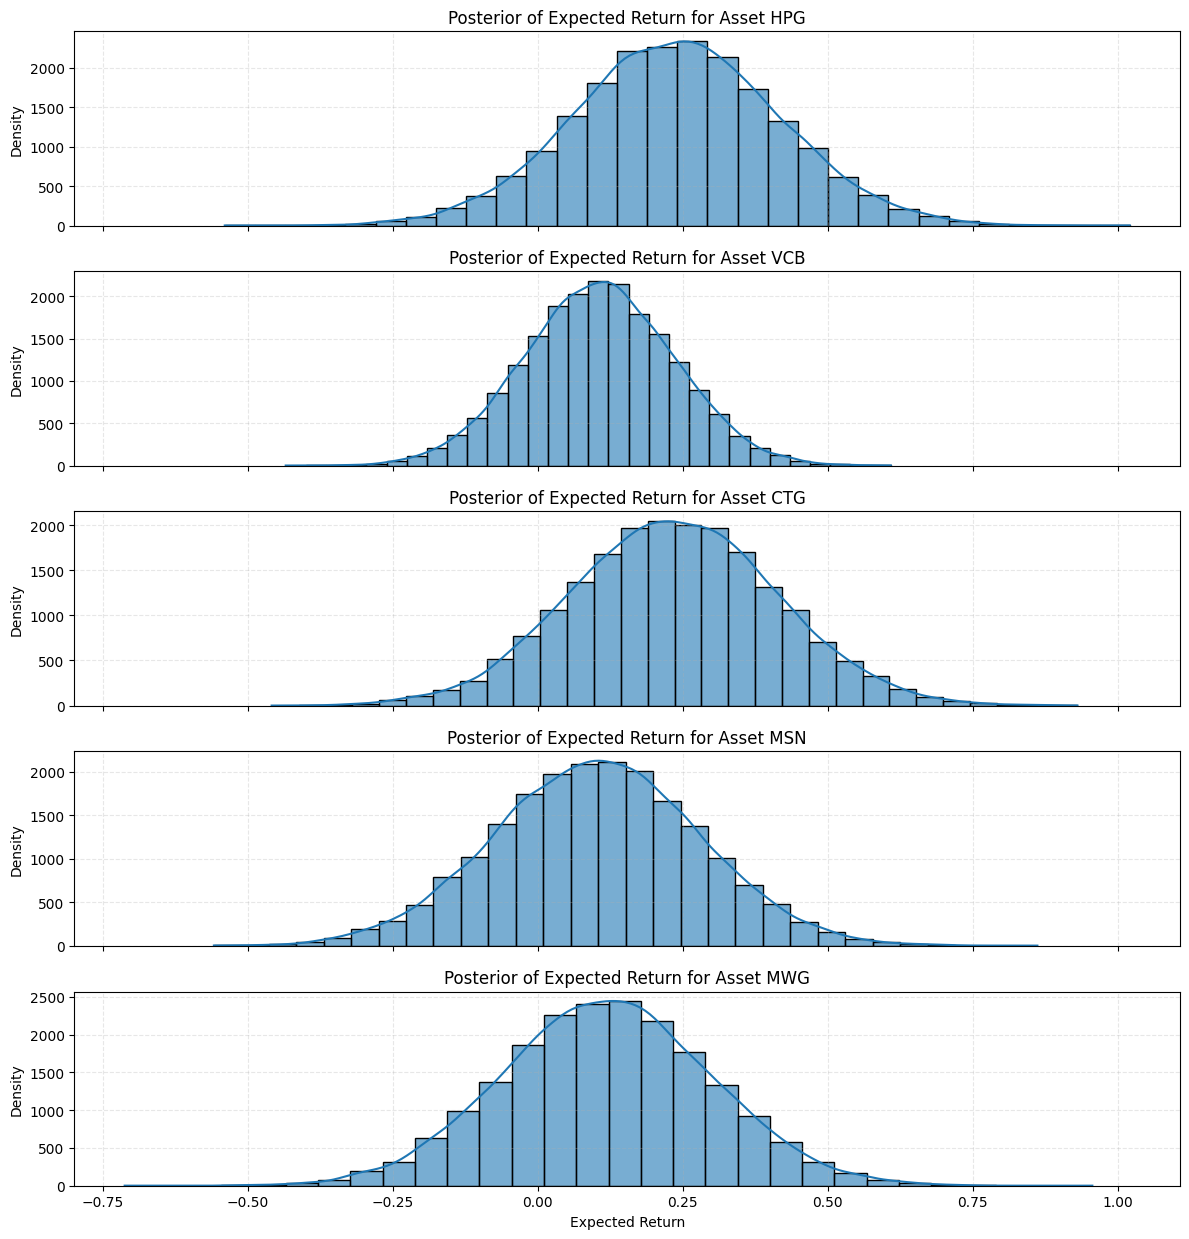

In [354]:
fig, axes = plt.subplots(n_assets, 1, figsize=(12, 2.5 * n_assets), sharex=True)

for i, name in enumerate(ASSETS):
    sns.histplot(samples_mu[:, i], bins=30, kde=True, ax=axes[i], color="tab:blue", alpha=0.6)
    axes[i].set_title(f"Posterior of Expected Return for Asset {name}")
    axes[i].set_xlabel("Expected Return")
    axes[i].set_ylabel("Density")
    axes[i].grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

In [355]:
def extract_posterior_samples(trace):
    mu_samples = trace.posterior['annual_returns'].values  # (chains, draws, assets)
    cov_samples = trace.posterior['annual_covariance_matrix'].values  # (chains, draws, assets, assets)
    # Flatten chains and draws
    mu_samples = mu_samples.reshape(-1, mu_samples.shape[-1])
    cov_samples = cov_samples.reshape(-1, cov_samples.shape[-2], cov_samples.shape[-1])
    n_samples = mu_samples.shape[0]
    return mu_samples, cov_samples, n_samples


## Result Variables

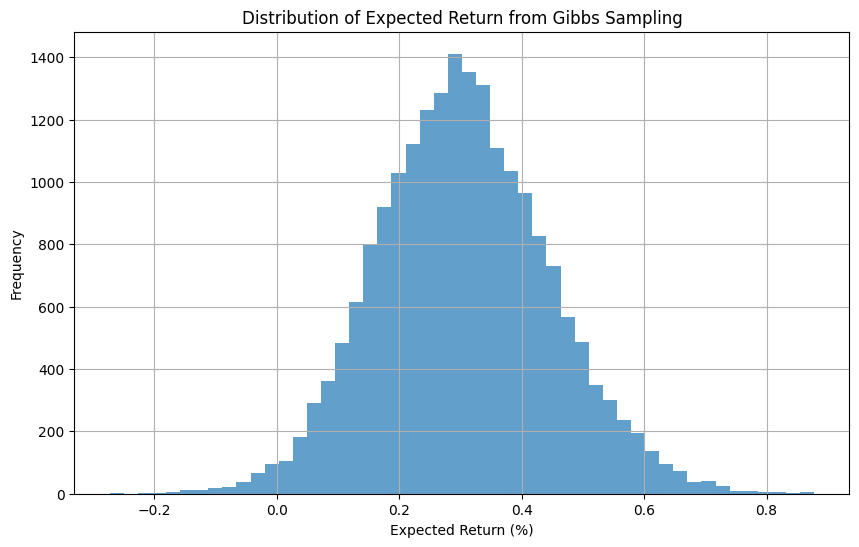

In [356]:
#Expacted Return Distribution (mu)
plt.figure(figsize=(10,6))
plt.hist(results["return"], bins=50, alpha=0.7, color="tab:blue")
plt.xlabel("Expected Return (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Expected Return from Gibbs Sampling")
plt.grid(True)
plt.show()

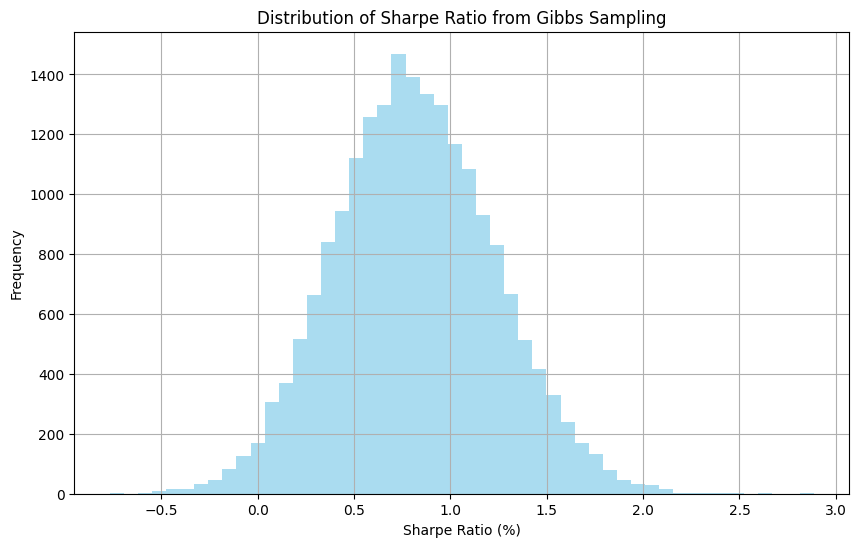

In [357]:
#Expacted Return Distribution (mu)
plt.figure(figsize=(10,6))
plt.hist(results["sharpe"], bins=50, alpha=0.7, color="skyblue")
plt.xlabel("Sharpe Ratio (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Sharpe Ratio from Gibbs Sampling")
plt.grid(True)
plt.show()

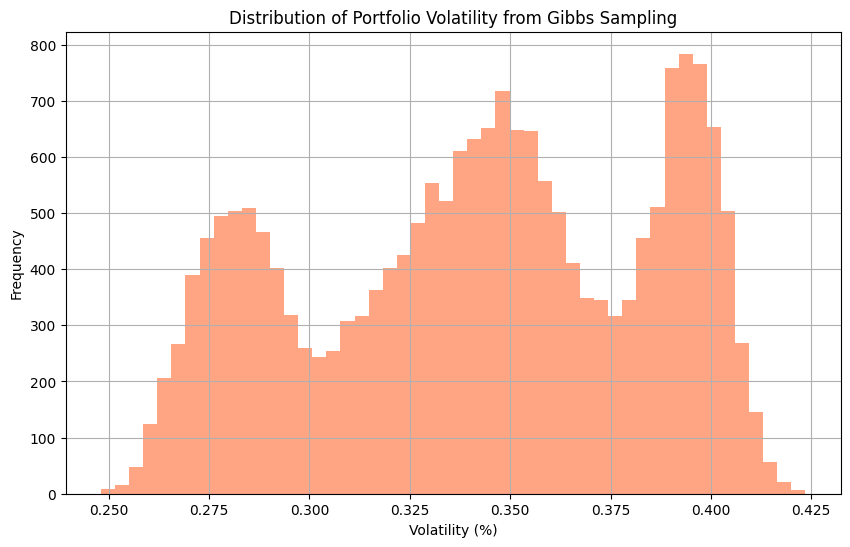

In [358]:
#Volatility Distribution (std)
plt.figure(figsize=(10,6))
plt.hist(results["volatility"], bins=50, alpha=0.7, color="coral")
plt.xlabel("Volatility (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Portfolio Volatility from Gibbs Sampling")
plt.grid(True)
plt.show()

In [359]:
import warnings

def calculate_hdi(samples, prob=0.94):
    
    samples = np.asarray(samples).flatten()
    sorted_samples = np.sort(samples)
    n = len(sorted_samples)
    
    n_include = int(np.floor(prob * n))
    
    interval_width = sorted_samples[n_include:] - sorted_samples[:n - n_include]
    min_idx = np.argmin(interval_width)
    
    hdi_lower = sorted_samples[min_idx]
    hdi_upper = sorted_samples[min_idx + n_include]
    
    return hdi_lower, hdi_upper

def calculate_effective_sample_size(samples):
    """
    Effective Sample Size (ESS) using autocorrelation
    
    Parameters:
    -----------
    samples : array-like

    
    Returns:
    --------
    float : ESS
    """
    samples = np.asarray(samples).flatten()
    n = len(samples)
    
    # Calculate autocorrelation
    # Standardize samples
    samples_centered = samples - np.mean(samples)
    
    # Compute autocorrelation using FFT
    f_vi = np.fft.fft(samples_centered, n=2*n)
    autocorr = np.fft.ifft(f_vi * np.conjugate(f_vi)).real
    autocorr = autocorr[:n] / autocorr[0]
    
    # Finding cutoff point where autocorrelation becomes negligible
    # Using windowed estimator
    tau_int = 1.0
    for k in range(1, min(n//4, 200)):
        if autocorr[k] <= 0:
            break
        tau_int += 2.0 * autocorr[k]
        if k >= 6 * tau_int:
            break
    
    ess = n / (2 * tau_int)
    return max(1.0, ess)

def calculate_mcmc_se(samples):
    """
    MCMC Standard Error
    
    Parameters:
    -----------
    samples : array-like
    
    Returns:
    --------
    float : MCMC SE
    """
    samples = np.asarray(samples).flatten()
    ess = calculate_effective_sample_size(samples)
    mcmc_se = np.std(samples, ddof=1) / np.sqrt(ess)
    return mcmc_se

def calculate_rhat(chains_list):
    """
    R-hat (Potential Scale Reduction Factor)
    
    Parameters:
    -----------
    chains_list : list of arrays
    
    Returns:
    --------
    float : R-hat value
    """
    if len(chains_list) == 1:
        chain = np.asarray(chains_list[0]).flatten()
        n_half = len(chain) // 2
        chains_list = [chain[:n_half], chain[n_half:2*n_half]]
    
    chains = [np.asarray(chain).flatten() for chain in chains_list]
    m = len(chains)  # chain
    n = min(len(chain) for chain in chains)  # minimum chain
    
    chains = [chain[:n] for chain in chains]
    
    # compute mean 
    chain_means = [np.mean(chain) for chain in chains]
    overall_mean = np.mean(chain_means)
    
    # Between-chain variance
    B = n * np.var(chain_means, ddof=1)
    
    # Within-chain variance
    chain_vars = [np.var(chain, ddof=1) for chain in chains]
    W = np.mean(chain_vars)
    
    # Pooled variance
    var_plus = ((n-1) * W + B) / n
    
    # R-hat
    if W > 0:
        rhat = np.sqrt(var_plus / W)
    else:
        rhat = 1.0
    
    return rhat

def calculate_bulk_ess(samples):
    """
    Calculate Bulk ESS
    """
    samples = np.asarray(samples).flatten()
    
    # Rank transformation
    ranks = stats.rankdata(samples)
    # Normalize ranks to [-1, 1]
    ranks_norm = 2 * (ranks - 1) / (len(ranks) - 1) - 1
    
    return calculate_effective_sample_size(ranks_norm)

def calculate_tail_ess(samples):
    """
    Calculate Tail ESS 
    """
    samples = np.asarray(samples).flatten()
    
    # Fold samples around median
    median = np.median(samples)
    folded = np.abs(samples - median)
    
    return calculate_effective_sample_size(folded)

def mcmc_summary_statistics(samples_dict, burnin=None):
    results = []
    
    for param_name, samples in samples_dict.items():
        samples = np.asarray(samples).flatten()
        
        if burnin is not None:
            samples = samples[burnin:]
        
        # expected return
        mean_val = np.mean(samples)
        std_val = np.std(samples, ddof=1)
        
        # HDI 94% (3% và 97%)
        hdi_lower, hdi_upper = calculate_hdi(samples, prob=0.94)
        
        # MCMC SE
        mcmc_se = calculate_mcmc_se(samples)
        
        # ESS variants
        bulk_ess = calculate_bulk_ess(samples)
        tail_ess = calculate_tail_ess(samples)
        
        # R-hat 
        rhat = calculate_rhat([samples])
        
        results.append({
            'Parameter': param_name,
            'Mean': mean_val,
            'SD': std_val,
            'HDI 3%': hdi_lower,
            'HDI 97%': hdi_upper,
            'MCSE': mcmc_se,
            'ESS Bulk': int(bulk_ess),
            'ESS Tail': int(tail_ess),
            'R̂': rhat
        })
    
    return pd.DataFrame(results)

def create_summary_for_gibbs_results(samples_mu, samples_cov, asset_names, burnin=5000):
    
    # dictionary cho expected returns
    samples_dict = {}
    
    # Expected Returns
    for i, asset in enumerate(asset_names):
        samples_dict[f'Expected_Returns_{asset}'] = samples_mu[:, i]
    
    # Covariance Matrix Elements 
    for i, asset in enumerate(asset_names):
        samples_dict[f'sigma2_{asset}'] = samples_cov[:, i, i]
    
    # summary statistics
    summary_df = mcmc_summary_statistics(samples_dict, burnin=burnin)
    
    summary_df['Mean'] = summary_df['Mean'].round(3)
    summary_df['SD'] = summary_df['SD'].round(3)
    summary_df['HDI 3%'] = summary_df['HDI 3%'].round(3)
    summary_df['HDI 97%'] = summary_df['HDI 97%'].round(3)
    summary_df['MCSE'] = summary_df['MCSE'].round(3)
    summary_df['R̂'] = summary_df['R̂'].round(1)
    
    return summary_df

if __name__ == "__main__":
    summary_table = create_summary_for_gibbs_results(
        samples_mu=samples_mu,
        samples_cov=samples_cov, 
        asset_names=ASSETS,
        burnin=5000
     )
    
    print("=== Gibbs Sampling SUMMARY STATISTICS ===")
    print(summary_table.to_string(index=False))
    

=== Gibbs Sampling SUMMARY STATISTICS ===
           Parameter  Mean    SD  HDI 3%  HDI 97%  MCSE  ESS Bulk  ESS Tail  R̂
Expected_Returns_HPG 0.240 0.177  -0.092    0.580 0.002      7294      7500 1.0
Expected_Returns_VCB 0.107 0.128  -0.135    0.344 0.001      7500      7345 1.0
Expected_Returns_CTG 0.236 0.177  -0.086    0.576 0.002      7500      7309 1.0
Expected_Returns_MSN 0.103 0.176  -0.229    0.435 0.002      7500      7324 1.0
Expected_Returns_MWG 0.118 0.181  -0.215    0.462 0.002      7158      7313 1.0
          sigma2_HPG 0.157 0.006   0.146    0.169 0.000      7270      7432 1.0
          sigma2_VCB 0.082 0.003   0.076    0.088 0.000      7429      7310 1.0
          sigma2_CTG 0.156 0.006   0.145    0.168 0.000      7500      7500 1.0
          sigma2_MSN 0.155 0.006   0.144    0.167 0.000      7362      7500 1.0
          sigma2_MWG 0.160 0.006   0.148    0.172 0.000      6937      7500 1.0



## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                

CVaR EVALUATION FROM GIBBS SAMPLES

Portfolio Statistics from Gibbs samples:
Expected Return: 30.52% ± 14.05%
Mean Volatility: 34.20% ± 4.24%
Mean Sharpe:     0.816 ± 0.415

Risk Measures:
VaR (1%):  -1.25%
CVaR (1%): -6.35%
VaR (5%):  8.30%
CVaR (5%): 2.54%


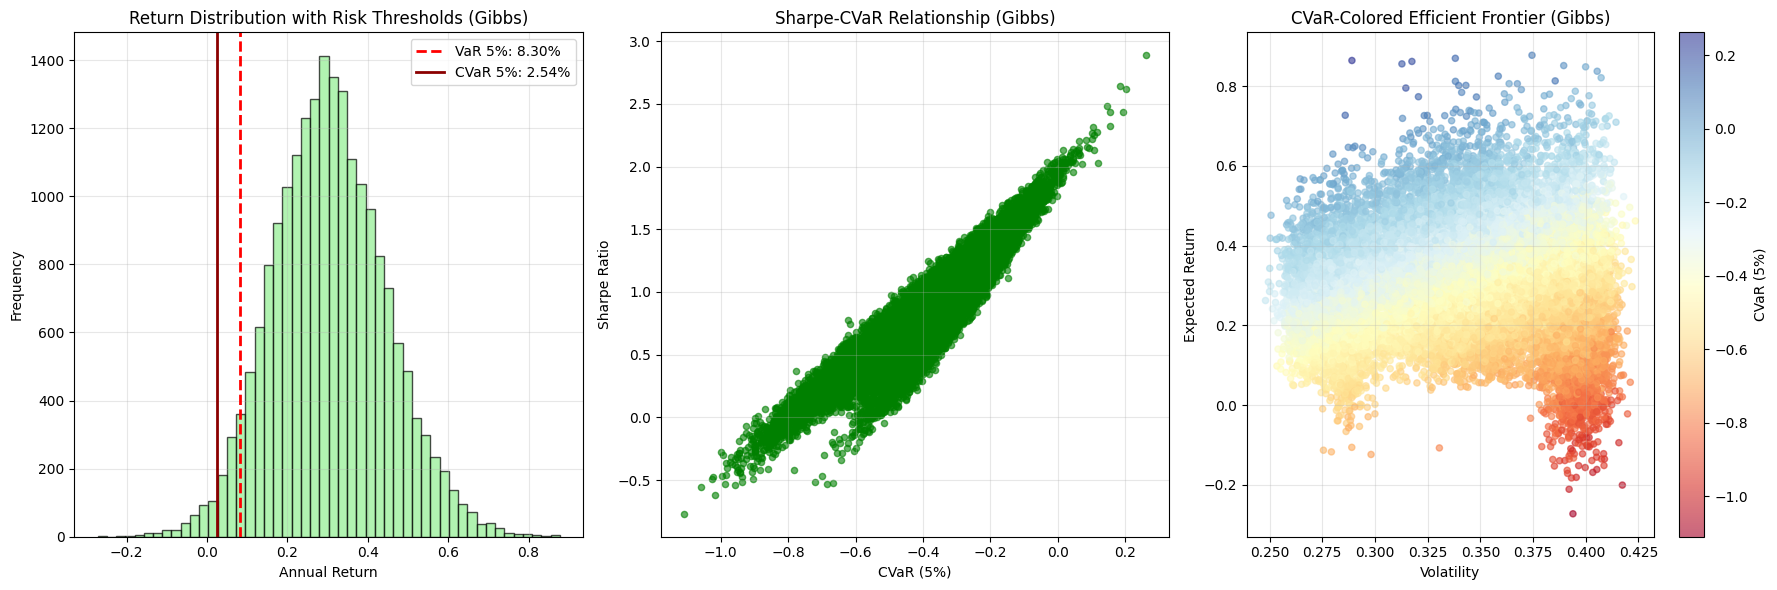


Risk-Return Trade-off Analysis (Gibbs):
CVaR Range (5%): [-110.97%, 26.28%]
Sharpe Range: [-0.769, 2.888]
Correlation (CVaR vs Sharpe): 0.927

Gibbs Sampling CVaR Summary:
Expected Return: 30.52%
Volatility:      34.20%
Sharpe Ratio:    0.816
VaR (5%):        8.30%
CVaR (5%):       2.54%



In [364]:
def calculate_var_cvar_from_distribution(returns, confidence_level=0.05):
    """
    Compute VaR and CVaR from the empirical distribution of returns.
    
    Parameters:
    -----------
    returns : Array of portfolio returns from Gibbs sampling.
    confidence_level : Confidence level (alpha), default is 0.05 (5%).
    
    Returns:
    --------
    tuple : (VaR, CVaR)
    """
    returns = np.array(returns)
    
    # VaR: Quantile at the specified confidence level
    var = np.percentile(returns, confidence_level * 100)
    
    # CVaR: Mean of all returns ≤ VaR
    tail_returns = returns[returns <= var]
    cvar = np.mean(tail_returns) if len(tail_returns) > 0 else var
    
    return var, cvar

print("CVaR EVALUATION FROM GIBBS SAMPLES")

# Retrieve returns from Gibbs results
gibbs_returns_array = np.array(results["return"])
gibbs_volatility_array = np.array(results["volatility"])
gibbs_sharpe_array = np.array(results["sharpe"])
gibbs_weights_array = np.array(results["weights"])
n_gibbs_samples = len(gibbs_returns_array)

print(f"\nPortfolio Statistics from Gibbs samples:")
print(f"Expected Return: {np.mean(gibbs_returns_array)*100:.2f}% ± {np.std(gibbs_returns_array)*100:.2f}%")
print(f"Mean Volatility: {np.mean(gibbs_volatility_array)*100:.2f}% ± {np.std(gibbs_volatility_array)*100:.2f}%")
print(f"Mean Sharpe:     {np.mean(gibbs_sharpe_array):.3f} ± {np.std(gibbs_sharpe_array):.3f}")

# Compute empirical VaR/CVaR from the return distribution
confidence_levels = [0.01, 0.05]
print(f"\nRisk Measures:")

for cl in confidence_levels:
    var_emp, cvar_emp = calculate_var_cvar_from_distribution(gibbs_returns_array, cl)
    print(f"VaR ({int(cl*100)}%):  {var_emp*100:.2f}%")
    print(f"CVaR ({int(cl*100)}%): {cvar_emp*100:.2f}%")
    
# VISUALIZATION FOR GIBBS SAMPLING
# Compute CVaR for each portfolio for color coding
gibbs_individual_cvars = []
for i in range(len(gibbs_returns_array)):
    # Assume each portfolio follows a normal distribution with its own mu and sigma
    portfolio_returns = np.random.normal(gibbs_returns_array[i], gibbs_volatility_array[i], 1000)
    _, cvar = calculate_var_cvar_from_distribution(portfolio_returns, 0.05)
    gibbs_individual_cvars.append(cvar)

gibbs_individual_cvars = np.array(gibbs_individual_cvars)

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Return distribution with risk thresholds
var_5_emp, cvar_5_emp = calculate_var_cvar_from_distribution(gibbs_returns_array, 0.05)

axes[0].hist(gibbs_returns_array, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0].axvline(var_5_emp, color='red', linestyle='--', linewidth=2, label=f'VaR 5%: {var_5_emp*100:.2f}%')
axes[0].axvline(cvar_5_emp, color='darkred', linestyle='-', linewidth=2, label=f'CVaR 5%: {cvar_5_emp*100:.2f}%')
axes[0].set_title('Return Distribution with Risk Thresholds (Gibbs)')
axes[0].set_xlabel('Annual Return')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Sharpe-CVaR relationship
axes[1].scatter(gibbs_individual_cvars, gibbs_sharpe_array, alpha=0.6, s=20, color='green')
axes[1].set_xlabel('CVaR (5%)')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_title('Sharpe-CVaR Relationship (Gibbs)')
axes[1].grid(True, alpha=0.3)

# 3. CVaR-colored efficient frontier
scatter = axes[2].scatter(
    gibbs_volatility_array,
    gibbs_returns_array,
    c=gibbs_individual_cvars,
    alpha=0.6,
    s=20,
    cmap='RdYlBu'
)
axes[2].set_xlabel('Volatility')
axes[2].set_ylabel('Expected Return')
axes[2].set_title('CVaR-Colored Efficient Frontier (Gibbs)')
plt.colorbar(scatter, ax=axes[2], label='CVaR (5%)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis for Gibbs
correlation_gibbs = np.corrcoef(gibbs_individual_cvars, gibbs_sharpe_array)[0,1]

print(f"\nRisk-Return Trade-off Analysis (Gibbs):")
print(f"CVaR Range (5%): [{np.min(gibbs_individual_cvars)*100:.2f}%, {np.max(gibbs_individual_cvars)*100:.2f}%]")
print(f"Sharpe Range: [{np.min(gibbs_sharpe_array):.3f}, {np.max(gibbs_sharpe_array):.3f}]")
print(f"Correlation (CVaR vs Sharpe): {correlation_gibbs:.3f}")

# Summary comparison table
print(f"\nGibbs Sampling CVaR Summary:")
print(f"Expected Return: {np.mean(gibbs_returns_array)*100:.2f}%")
print(f"Volatility:      {np.mean(gibbs_volatility_array)*100:.2f}%")
print(f"Sharpe Ratio:    {np.mean(gibbs_sharpe_array):.3f}")
print(f"VaR (5%):        {var_5_emp*100:.2f}%")
print(f"CVaR (5%):       {cvar_5_emp*100:.2f}%")

print("\n" + "="*60)
